In [216]:
#!pip install Pydub
#!pip install PyWavelets
#!pip install openl3
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pywt
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler, LabelEncoder
import audioread
from pydub import AudioSegment
import tensorflow as tf
#from tensorflow.keras import layers, models
#import openl3
import audioread
import tensorflow_hub as hub
from keras import layers, models, preprocessing
import keras.backend as K
from keras.preprocessing.sequence import pad_sequences
from keras import mixed_precision
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import math
import random
import matplotlib.pyplot as plt

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Load the datasets
#file_30_sec = 'data/GTZAN/features_30_sec.csv'
#file_3_sec = 'data/GTZAN/features_3_sec.csv'

file_30_sec = '/content/drive/MyDrive/DS4420_Project/data/GTZAN/features_30_sec.csv'
file_3_sec = '/content/drive/MyDrive/DS4420_Project/data/GTZAN/features_3_sec.csv'
audio_directory = '/content/drive/MyDrive/DS4420_Project/data/GTZAN/genres_original'

df_30_sec = pd.read_csv(file_30_sec)
df_3_sec = pd.read_csv(file_3_sec)

In [5]:
# Load VGGish model from TensorFlow Hub
vggish_model = hub.load('https://tfhub.dev/google/vggish/1')

# Function to extract VGGish features with correct preprocessing
def extract_vggish_features(y, sr, file_path):
    try:
        # Resample the audio to 16 kHz for VGGish input
        y_resampled = librosa.resample(y, orig_sr=sr, target_sr=16000)

        # Ensure input is in float32 format
        y_resampled = np.array(y_resampled, dtype=np.float32)

        # VGGish expects an input with shape [num_samples], no batch dimension
        # Convert to tensor for the model
        y_tensor = tf.convert_to_tensor(y_resampled, dtype=tf.float32)

        # Extract features using VGGish model
        vggish_features = vggish_model(y_tensor)

        # If output is a tensor, convert it to numpy array
        if isinstance(vggish_features, tf.Tensor):
            vggish_features = vggish_features.numpy()

        # Flatten the features to use in ML models
        vggish_features_flattened = vggish_features.flatten()
    except Exception as e:
        print(f"Error extracting VGGish features from {file_path}: {e}")
        vggish_features_flattened = None

    return vggish_features_flattened

def extract_features(file_path, sr=22050, n_mels=128, wavelet='db1'):
    try:
        # Load audio file
        y, sr = librosa.load(file_path, sr=sr)
        # Ensure input is in float32 format
        y = np.array(y, dtype=np.float32)

        # Extract Mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        mel_spectrogram_flattened = mel_spectrogram_db.flatten()  # Flatten for use in ML models

        # Extract wavelet features
        coeffs = pywt.wavedec(y, wavelet, level=5)
        wavelet_features = np.concatenate([np.array(c).flatten() for c in coeffs])

        # Extract VGGish features
        vggish_features_flattened = extract_vggish_features(y, sr, file_path)

        # Combine all features independently into a dictionary (without chroma)
        features = {
            'mel_spectrogram': mel_spectrogram_flattened,
            'wavelet': wavelet_features,
            'vggish': vggish_features_flattened if vggish_features_flattened is not None else np.array([])
        }
    except Exception as e:
        print(f"Error processing audio file {file_path}: {e}")
        features = {
            'mel_spectrogram': np.array([]),
            'wavelet': np.array([]),
            'vggish': np.array([])
        }

    return features

# Function to process the entire dataset and extract features
# and combine them with existing CSV features
def process_dataset(df, audio_directory):
    features = {
        'mel_spectrogram': [],
        'wavelet': [],
        'vggish': [],
        'mfcc': [],
        'chroma': [],
        'rms': [],
        'spectral_centroid': [],
        'spectral_bandwidth': [],
        'zero_crossing_rate': [],
        'tempo': []
    }
    labels = []

    for idx, row in df.iterrows():
        file_path = os.path.join(audio_directory, row['label'], row['filename'])
        extracted_features = extract_features(file_path)

        # Check if all extracted features are empty
        if all(len(extracted_features[key]) == 0 for key in extracted_features):
            print(f"Skipping row {idx} due to audio extraction issues.")
            continue  # Optionally skip the row with extraction issues

        # Extract CSV features
        mfcc_features = row.filter(like='mfcc').values.astype(np.float32)
        chroma_features = row.filter(like='chroma').values.astype(np.float32)
        rms_features = row.filter(like='rms').values.astype(np.float32)
        spectral_centroid_features = row.filter(like='spectral_centroid').values.astype(np.float32)
        spectral_bandwidth_features = row.filter(like='spectral_bandwidth').values.astype(np.float32)
        zero_crossing_rate_features = row.filter(like='zero_crossing_rate').values.astype(np.float32)
        tempo_features = row.filter(like='tempo').values.astype(np.float32)

        # Add CSV features and extracted features to their respective lists
        features['mfcc'].append(mfcc_features)
        features['chroma'].append(chroma_features)
        features['rms'].append(rms_features)
        features['spectral_centroid'].append(spectral_centroid_features)
        features['spectral_bandwidth'].append(spectral_bandwidth_features)
        features['zero_crossing_rate'].append(zero_crossing_rate_features)
        features['tempo'].append(tempo_features)
        for key in extracted_features:
            features[key].append(extracted_features[key])

        # Add label
        labels.append(row['label'])

    # Convert features lists to NumPy arrays without padding/truncation
    for key in features:
        features[key] = np.array(features[key], dtype=object)  # Keep features as arrays of varying lengths

    labels = np.array(labels)

    return features, labels

# Function to standardize features (without padding or truncation)
def standardize_features(features):
    standardized_features = {}
    scalers = {}

    for key in features:
        standardized_features[key] = []
        scalers[key] = []
        for feature in features[key]:
            feature = feature.reshape(-1, 1)  # Reshape to 2D for StandardScaler
            scaler = StandardScaler()
            standardized_feature = scaler.fit_transform(feature).flatten()
            standardized_features[key].append(standardized_feature)
            scalers[key].append(scaler)  # Save scaler for future use (e.g., test data)
        standardized_features[key] = np.array(standardized_features[key], dtype=object)  # Keep as object array for varying lengths

    return standardized_features, scalers

In [6]:
features, labels = process_dataset(df_30_sec, audio_directory)

<ipython-input-5-b84727e532e6>:35: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing audio file /content/drive/MyDrive/DS4420_Project/data/GTZAN/genres_original/jazz/jazz.00054.wav: 
Skipping row 554 due to audio extraction issues.


In [7]:
# Standardize features before splitting
standardized_features, scalers = standardize_features(features)

# Split dataset into training, validation, and test sets
train_features = {}
val_features = {}
test_features = {}
# Create a combined list of feature dictionaries and labels for consistent splitting
combined_data = list(zip([{key: features[key][i] for key in features} for i in range(len(labels))], labels))

# Split combined data
train_data, test_data = train_test_split(combined_data, test_size=0.2, random_state=42, stratify=labels)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42, stratify=[label for _, label in train_data])  # 0.25 * 0.8 = 0.2 for validation set

# Separate features and labels after splitting
for key in features:
    train_features[key] = [data[0][key] for data in train_data]
    val_features[key] = [data[0][key] for data in val_data]
    test_features[key] = [data[0][key] for data in test_data]

train_labels = np.array([data[1] for data in train_data])
val_labels = np.array([data[1] for data in val_data])
test_labels = np.array([data[1] for data in test_data])


In [223]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Encode labels as integers
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
train_labels = label_encoder.transform(train_labels)
val_labels = label_encoder.transform(val_labels)
test_labels = label_encoder.transform(test_labels)

# CNN-RNN Hybrid Model for Music Genre Classification with Global Pooling and RNN
def create_hybrid_model(input_shapes, num_classes):
    inputs = []
    processed_features = []

    for key, shape in input_shapes.items():
        input_layer = layers.Input(shape=(None, 1), name=f"{key}_input")
        inputs.append(input_layer)

        if key == 'mel_spectrogram':
            # Calculate the time dimension dynamically and ensure divisibility by 128
            time_dimension = layers.Lambda(lambda x: tf.shape(x)[1] // 128)(input_layer)
            # Pad the input to ensure divisibility by 128
            padded_input = layers.Lambda(lambda x: tf.pad(x, [[0, 0], [0, 128 - tf.shape(x)[1] % 128], [0, 0]]))(input_layer)
            # Reshape the padded input with the calculated time dimension using a Reshape layer
            input_layer_mel = layers.Reshape((-1, 128, 1))(padded_input)
            # Use Conv2D for Mel spectrogram with Global Average Pooling
            x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer_mel)  # Use Conv2D for 2D features
            x = layers.BatchNormalization()(x)
            x = layers.SpatialDropout2D(0.2)(x)  # Use SpatialDropout2D to drop entire feature maps
            #x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)  # Add a second Conv2D layer
            #x = layers.BatchNormalization()(x)
            x = layers.MaxPooling2D((2, 2))(x)  # Use 2D max pooling
            x = layers.GlobalAveragePooling2D()(x)
        elif key == 'wavelet':
            # Use RNN for wavelet features
            x = layers.LSTM(32, return_sequences=True)(input_layer)  # Reduce units to 32, Disable cuDNN
            x = layers.BatchNormalization()(x)
            x = layers.SpatialDropout1D(0.2)(x)
            x = layers.LSTM(16, return_sequences=True)(x)  # Add another LSTM layer with fewer units
            x = layers.BatchNormalization()(x)
            x = layers.GlobalAveragePooling1D()(x)
        elif key == 'vggish':
            # Use Dense layers for VGGish features
            x = layers.Dense(32, activation='relu')(input_layer)  # Reduce units to 32
            x = layers.BatchNormalization()(x)
            x = layers.Dropout(0.3)(x)
            x = layers.GlobalAveragePooling1D()(x)
        elif key == 'mfcc':
            # Use RNN for MFCC features
            x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(input_layer)
            x = layers.BatchNormalization()(x)
            x = layers.SpatialDropout1D(0.2)(x)
            #x = layers.Bidirectional(layers.LSTM(16, return_sequences=True))(x)
            #x = layers.BatchNormalization()(x)
            x = layers.GlobalAveragePooling1D()(x)
        elif key == 'chroma':
            # Use Dense layers for Chroma features
            x = layers.Dense(16, activation='relu')(input_layer)  # Reduce units to 16
            x = layers.BatchNormalization()(x)
            x = layers.Dropout(0.3)(x)
            x = layers.GlobalAveragePooling1D()(x)
        processed_features.append(x)

    # Concatenate all processed features
    combined = layers.concatenate(processed_features)
    x = layers.Dense(64, activation='relu')(combined)  # Reduce units to 64
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    output_layer = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=output_layer)
    return model


In [224]:
# Define input shapes for the model
input_shapes = {
    'mel_spectrogram': (None, 1),
    'wavelet': (None, 1),
    'vggish': (None, 1),
    'mfcc': (None, 1),
    'chroma': (None, 1),
}
num_classes = len(set(labels))

# Pad features to ensure consistent input shape
lengths = [len(seq) for feature in train_features.values() for seq in feature]
max_len = int(np.percentile(lengths, 70))
padded_train_features = {key+'_input': pad_sequences(train_features[key], maxlen=max_len, padding='post', truncating='post', dtype='float32') for key in train_features}
padded_val_features = {key+'_input': pad_sequences(val_features[key], maxlen=max_len, padding='post', truncating='post', dtype='float32') for key in val_features}
padded_test_features = {key+'_input': pad_sequences(test_features[key], maxlen=max_len, padding='post', truncating='post', dtype='float32') for key in test_features}

# Set mixed precision policy
policy = mixed_precision.set_global_policy('float32')

# Define learning rate schedule
def combined_lr_schedule(epoch, lr_max, lr_min, warmup_epochs, T_max):
    if epoch < warmup_epochs:
        # Warm-up phase: gradually increase learning rate
        return lr_min + (lr_max - lr_min) * (epoch / warmup_epochs)
    else:
        # Cosine annealing phase after warm-up
        return lr_min + (lr_max - lr_min) * (1 + math.cos((epoch - warmup_epochs) * math.pi / T_max)) / 2

# Updated Parameters
lr_max = 1e-2  # Maximum learning rate (adjusted to a larger value)
lr_min = 1e-6  # Minimum learning rate (adjusted to a smaller value)
warmup_epochs = 10  # Number of epochs for warm-up
T_max = 240  # Cosine annealing cycles after warm-up (total_epochs - warmup_epochs)

# Set the learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lambda epoch: combined_lr_schedule(epoch, lr_max, lr_min, warmup_epochs, T_max))

# Define Adam optimizer with an initial learning rate
optimizer = Adam(learning_rate=lr_max)  # Initial learning rate is set to `lr_max`

# Create and compile the model
model = create_hybrid_model(input_shapes, num_classes)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ mel_spectrogram_input     │ (None, None, 1)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_42 (Lambda)        │ (None, None, 1)        │              0 │ mel_spectrogram_input… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ wavelet_input             │ (None, None, 1)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_24 (Reshape)      │ (None, None, 128, 1)   │              0 │ lambda_42[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_145 (LSTM)           │ (None, None, 32)       │          4,352 │ wavelet_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_36 (Conv2D)        │ (None, None, 128, 16)  │            160 │ reshape_24[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_406   │ (None, None, 32)       │            128 │ lstm_145[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vggish_input (InputLayer) │ (None, None, 1)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mfcc_input (InputLayer)   │ (None, None, 1)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ chroma_input (InputLayer) │ (None, None, 1)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_405   │ (None, None, 128, 16)  │             64 │ conv2d_36[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout1d_106     │ (None, None, 32)       │              0 │ batch_normalization_4… │
│ (SpatialDropout1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_268 (Dense)         │ (None, None, 32)       │             64 │ vggish_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_9           │ (None, None, 64)       │          8,704 │ mfcc_input[0][0]       │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_269 (Dense)         │ (None, None, 16)       │             32 │ chroma_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_26      │ (None, None, 128, 16)  │              0 │ batch_normalization_4… │
│ (SpatialDropout2D)        │                        │                │                        │
├──────────────────────

 Total params: 27,338 (106.79 KB)

 Trainable params: 26,858 (104.91 KB)

 Non-trainable params: 480 (1.88 KB)

In [225]:
# Training the model
history = model.fit(
    padded_train_features,
    train_labels.astype('int32'),
    validation_data=(padded_val_features, val_labels.astype('int32')),
    epochs=250,
    batch_size=64,
    callbacks=[lr_scheduler]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(
    padded_test_features,
    test_labels.astype('int32')
)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Make predictions
predictions = model.predict(padded_test_features)
predicted_labels = np.argmax(predictions, axis=1)
print(f"Predicted Labels: {predicted_labels}")
print(f"True Labels: {test_labels.astype('int32')}")

Epoch 1/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 231ms/step - accuracy: 0.0883 - loss: 3.2021 - val_accuracy: 0.0850 - val_loss: 2.3085 - learning_rate: 1.0000e-06
Epoch 2/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 0.0803 - loss: 3.1239 - val_accuracy: 0.0700 - val_loss: 2.3062 - learning_rate: 0.0010
Epoch 3/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 0.1094 - loss: 2.8489 - val_accuracy: 0.1050 - val_loss: 2.3045 - learning_rate: 0.0020
Epoch 4/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 0.1707 - loss: 2.4691 - val_accuracy: 0.1250 - val_loss: 2.3656 - learning_rate: 0.0030
Epoch 5/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.1997 - loss: 2.2867 - val_accuracy: 0.1000 - val_loss: 2.4100 - learning_rate: 0.0040
Epoch 6/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.2057 - loss: 2.2236 - val_accuracy: 0.1000 - val_loss: 2.4922 - learning_rate: 0.0050
Epoch 7/250
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.2685 - loss

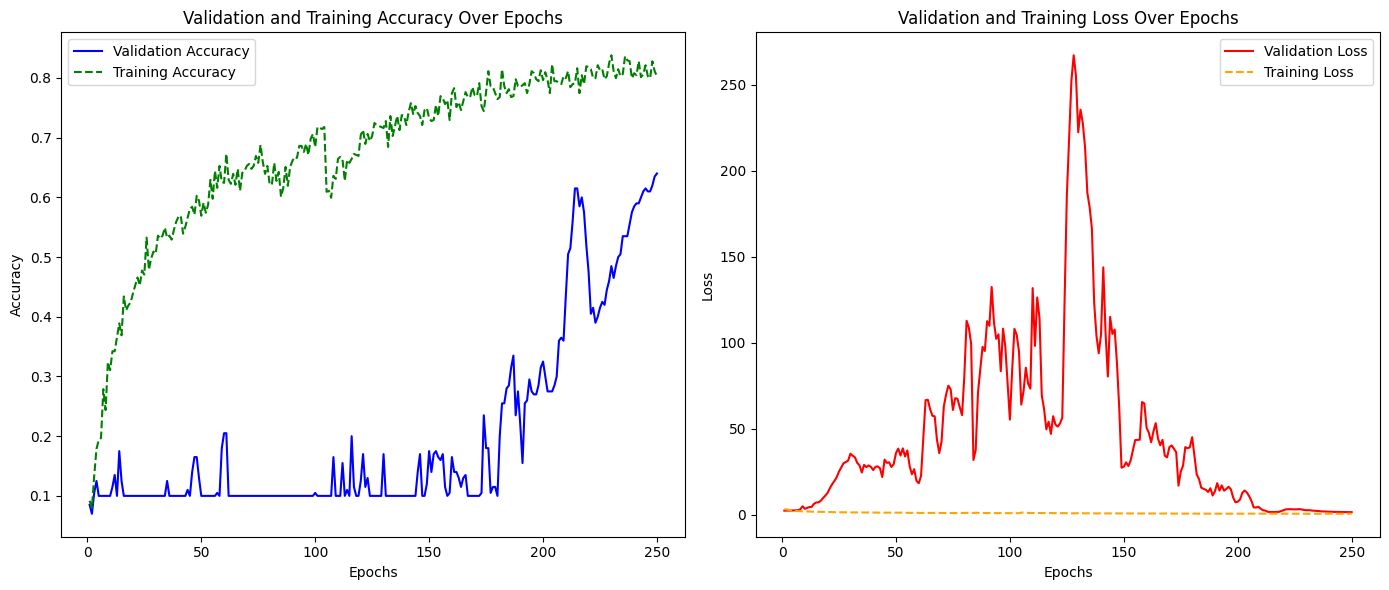

In [226]:
# Assuming you have trained the model, the history object contains the training data
# Retrieve data from the history object for accuracy and loss
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
loss = history.history['loss']

# Set x-axis as the number of epochs
epochs = range(1, len(val_accuracy) + 1)

# Create a figure with two subplots for accuracy and loss
plt.figure(figsize=(14, 6))

# Subplot 1: Validation and Training Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='b')
plt.plot(epochs, accuracy, label='Training Accuracy', color='g', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation and Training Accuracy Over Epochs')
plt.legend()

# Subplot 2: Validation and Training Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, val_loss, label='Validation Loss', color='r')
plt.plot(epochs, loss, label='Training Loss', color='orange', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation and Training Loss Over Epochs')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()